In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import time
import os
import numpy as np
from pathlib import Path
from PIL import Image
import helper
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from torchvision import datasets
from torchvision import datasets, transforms, models
from torch import nn, optim, Tensor
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from tqdm import tqdm

seed=42
torch.manual_seed(14)

/home/caloja/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-16 09:13:03.480765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 09:13:04.145836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-16 09:13:04.145889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
device = torch.device('cpu')
print('Using device:', device)
print()

Using device: cpu



In [4]:
class RGBCloudDataset (Dataset):
    def __init__(self, red_dir, blue_dir, green_dir, gt_dir, n_samples=10000,transform= None):
        self.transform   = transform

        self.files = [self.combine_files(f, green_dir, blue_dir,gt_dir) 
                      for f in red_dir.iterdir() if not f.is_dir()]
        
        random.seed (seed)
        self.files = random.sample (self.files, k= n_samples)   
        
    def combine_files(self, red_file: Path, green_dir, blue_dir,  gt_dir):
        
        files = {'red': red_file, 
                 'green':green_dir/red_file.name.replace('red', 'green'),
                 'blue': blue_dir/red_file.name.replace('red', 'blue'), 
                 'gt': gt_dir/red_file.name.replace('red', 'gt')}

        return files
    
    
    
    def OpenAsArray(self, idx, invert=False):
        
        raw_rgb=np.stack([np.array(Image.open(self.files[idx]['red'])),
                          np.array(Image.open(self.files[idx]['green'])),
                          np.array(Image.open(self.files[idx]['blue']))], axis = 2)
     

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
    
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    
    
    
    def OpenMask(self, idx, add_dims=False):
        # print(self.files[idx]['gt'])
        raw_mask=np.array(Image.open(self.files[idx]['gt']))
        # raw_mask = np.where(raw_mask==255, 1, 0)
        
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask



        
    def __len__(self):
        
        return len(self.files)
    
    
    
    def __getitem__(self, idx):
        
        x=self.OpenAsArray(idx, invert=True, )
        y=self.OpenMask(idx, add_dims=False)

        if self.transform is not None:
            x , y= self.transform((x,y))
            

        x = torch.tensor(x,dtype=torch.float32)
        y = torch.tensor(y,dtype=torch.float32)
        
        return x, y
    
    
    
    def open_as_pil(self, idx):
        
        arr = 256 * self.OpenAsArray(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')  
    
    
    
    def __repr__(self):
        
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [6]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, Evaluation, epochs, save_path):
    
    start = time.time()
    min_valid_epoch_loss = np.inf
    best_DSC = 0.0
    train_losses, valid_losses = [], []
    train_DSC, train_IoU, train_recall, train_precision = [], [], [], [] 
    valid_DSC, valid_IoU, valid_recall, valid_precision = [], [], [], [] 

    for e in tqdm(range(epochs)):
        print('Epoch  {}/{}'.format(e, epochs-1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to train mode
                dataloader = train_dl
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_DSC  = 0.0
            running_IoU  = 0.0
            running_recall  = 0.0
            running_precision  = 0.0


            # iterate over data
            for x, y in dataloader:
                x = x.to('cpu', dtype=torch.float)
                y = y.to('cpu')

                # forward pass 
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss    = loss_fn(outputs, y)

                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss    = loss_fn(outputs, y)

                acc = Evaluation(outputs, y)
                running_DSC        += acc['Dice_Score/F1_Score'].item()* dataloader.batch_size
                running_IoU        += acc['IoU'].item()* dataloader.batch_size
                running_recall     += acc['Recall'].item()* dataloader.batch_size
                running_precision  += acc['Precision'].item()* dataloader.batch_size    
                
                running_loss += loss.item() * dataloader.batch_size
                    
            epoch_loss       = running_loss/ len(dataloader.dataset)
            epoch_DSC        = running_DSC / len(dataloader.dataset)
            epoch_IoU        = running_IoU / len(dataloader.dataset)
            epoch_Recall     = running_recall / len(dataloader.dataset)
            epoch_Precision  = running_precision / len(dataloader.dataset)
            

            print('{}\nDice Loss: {:.3f}\tDice Coefficient: {:.3f}\tJaccard Coefficient: {:.3f}\tPrecision: {:.3f}\tRecall: {:.3f}'.format( phase, epoch_loss, epoch_DSC, epoch_IoU, epoch_Precision, epoch_Recall))
            print()

            train_losses.append(epoch_loss), train_DSC.append(epoch_DSC),train_IoU.append(epoch_IoU),train_recall.append(epoch_Recall),train_precision.append(epoch_Precision) if phase=='train' else valid_losses.append(epoch_loss), valid_DSC.append(epoch_DSC),valid_IoU.append(epoch_IoU),valid_recall.append(epoch_Recall),valid_precision.append(epoch_Precision)

            
             
             # save model if validation loss has decreased
            if phase == 'valid':
                if epoch_loss <= min_valid_epoch_loss:
                    print('Validation Dice loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
                        min_valid_epoch_loss, epoch_loss)) 
                    print('Best Validation Dice Score ({:.3f} --> {:.3f}).'.format(
                        best_DSC, epoch_DSC))
                    torch.save(model.state_dict(), save_path)
                    min_valid_epoch_loss = epoch_loss
                    best_DSC = epoch_DSC
            

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    
    return train_losses, valid_losses, train_DSC, train_IoU, train_recall, train_precision,valid_DSC, valid_IoU, valid_recall, valid_precision, best_DSC

In [ ]:
def plot_DSC(train_DSC, valid_DSC):
    fig = plt.figure(figsize=(10, 10))
    plt.plot(train_DSC, '-bx')
    plt.plot(valid_DSC, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient vs. No. of epochs');
    
def plot_losses(train_losses, valid_losses):
    fig = plt.figure(figsize=(10, 10))
    plt.plot(train_losses, '-bx')
    plt.plot(valid_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('- Log Dice loss')
    plt.legend(['Training', 'Validation'])
    plt.title('- Log Dice Loss vs. No. of epochs');

In [7]:
class UpsamplerBloc(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, img_size, kern_size):
        super().__init__()
        self.upsampleBlock = nn.Sequential(*list((
          nn.Conv2d(in_channels,mid_channels, kernel_size = kern_size, bias=False),
          nn.BatchNorm2d(mid_channels),
          nn.ReLU(),
          nn.Conv2d(mid_channels,out_channels, kernel_size = kern_size, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.Upsample(size=(img_size,img_size), mode='bilinear', align_corners=False))))
    
    def forward(self, up_x, down_x):
        x = self.upsampleBlock(up_x)
        x = torch.cat([x, down_x],1)


class ResNet34FCN(nn.Module):
    DEPTH= 6
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        resnet = models.resnet34(pretrained=True)
        
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        
        up_blocks.append(UpsamplerBloc(512, 512, 256, 30, 3))
        up_blocks.append(UpsamplerBloc(256,256,128,60,3))
        up_blocks.append(UpsamplerBloc(128, 128, 64, 120, 3))
        up_blocks.append(UpsamplerBloc(64, 64, 2, 240, 3))
        self.up_blocks = nn.ModuleList(up_blocks)
        


    def forward(self, x):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)


        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (ResNet34FCN.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{ResNet34FCN.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        
        return x


In [8]:
# Evaluation Metrics

class Evaluation_Metrics(nn.Module):
    def __init__(self):
        super(Evaluation_Metrics, self).__init__()

    def forward(self, prediction, gt, smooth=1):
        
        pred = torch.round(prediction.softmax(dim=1)[:, 1])

        # true positives, false positives, true negatives, false negatives
        TP = torch.sum(pred * gt)
        FP = torch.sum(pred * (1-gt))
        TN = torch.sum((1-pred) * (1-gt))
        FN = torch.sum((1-pred) * gt)
    
    
        # Dice_Score/F1_Score
        Dice_Score = (2 * TP + smooth)/(2*TP + FP + FN  + smooth)
    
        # Jaccard Coefficient: Intersection over Union
        IoU = (TP + smooth)/(TP + FP + FN + smooth)
    
        # Recall
        Recall= (TP + smooth)/(TP + FN + smooth)
    
        # Precision
        Precision = (TP + smooth)/(TP + FP + smooth)

    
        return {'Dice_Score/F1_Score':Dice_Score, 'IoU':IoU, 'Recall': Recall, 'Precision': Precision}


# Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self,prediction, gt, smooth=1):
        
        # Softmax to get probabilities beteen 0 and 1
        # Transform the prediction tensor of shape (N, C, H, W) --> tensor of shape (N, H, W)
        pred = prediction.softmax(dim=1)[:, 1]
        
        #flatten label and prediction tensors
        pred = pred.contiguous().view(-1)
        gt = gt.contiguous().view(-1).to(torch.float32)
        
        intersection = (pred * gt).sum()                            
        dice_loss =(2.*intersection + smooth)/(pred.sum() + gt.sum() + smooth)  
        
        return -torch.log(dice_loss)
    

#Binary cross-entropy (BCE)-Dice loss function
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, prediction, gt, smooth=1):
        
        # Softmax to get probabilities beteen 0 and 1
        # Transform the prediction tensor of shape (N, C, H, W) --> tensor of shape (N, H, W)
        pred = prediction.softmax(dim=1)[:, 1]
        
        #flatten label and prediction tensors
        pred = pred.contiguous().view(-1)
        gt = gt.contiguous().view(-1).to(torch.float32)
        
        intersection = (pred * gt).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(pred.sum() + gt.sum() + smooth)  
        BCE = F.binary_cross_entropy(pred, gt, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [9]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )

class UpsamplerBlockWithSkip(nn.Module):
    def __init__(self, in_channels, out_channels, in_conv_channels=None, out_conv_channels=None):
        super().__init__()
        if (not in_conv_channels):
          in_conv_channels = in_channels
        if (not out_conv_channels):
          out_conv_channels = out_channels
        self.double_conv = double_conv(in_conv_channels + out_conv_channels, in_conv_channels)
        self.upsample =  up_conv(in_channels, out_channels)
    
    def forward(self, up_x, down_x=None):
        x = self.double_conv(up_x)
        x = self.upsample(x)
        if(down_x != None):
          x = torch.cat([x, down_x],1)
        return x

class ResNet34FCN_384(nn.Module):

    def __init__(self, *, out_channels=2,pretrained = True):
        super().__init__()
        self.encoder = models.resnet34(pretrained=pretrained)
        self.encoder_layers = list(self.encoder.children())

        self.block1 = nn.Sequential(*self.encoder_layers[:3])
        self.block2 = nn.Sequential(*self.encoder_layers[3:5])
        self.block3 = self.encoder_layers[5]
        self.block4 = self.encoder_layers[6]
        self.block5 = self.encoder_layers[7]

        self.up_conv6 = up_conv(512, 512)

        self.up_block7 = UpsamplerBlockWithSkip(512,256)
        self.up_block8 = UpsamplerBlockWithSkip(256,128)
        self.up_block9 = UpsamplerBlockWithSkip(128,64)
        self.up_block10 = UpsamplerBlockWithSkip(64,32,64,64)
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        if not pretrained:
            self._weights_init()

    def _weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        x = self.up_conv6(block5)
        x = torch.cat([x, block4], dim=1)

        x = self.up_block7(x,block3)

        x = self.up_block8(x,block2)
        
        x = self.up_block9(x,block1)
        
        x = self.up_block10(x)
        
        x = self.out(x)

        return x

In [10]:
from skimage.transform import resize

class Resize(object):
    def __init__(self, size = 256):
        self.size = size
    def __call__(self, sample):
        x, y = sample
        return (resize(x, (x.shape[0], self.size, self.size), mode = "constant", 
                      preserve_range = True, anti_aliasing = False),
                resize(y, (self.size, self.size), mode = "constant", 
                      preserve_range = True, anti_aliasing = False))
    

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, sample):
        x,y =sample
        x = x.transpose(1,2,0)
        x=(x-self.mean)/self.std
        return x.transpose(2,0,1), y
    
    
# TODO: Define transforms for the training data and testing data
train_transforms=transforms.Compose([Resize(256),
                                     Normalize([0.485, 0.456, 0.406], [0.229, 0.224,0.225])])

                                 
test_transforms=transforms.Compose(Normalize([0.485, 0.456, 0.406], [0.229, 0.224,0.225]))

In [11]:
base_path = Path('./data_landsat/preprocessed_3/')
red_dir   = base_path/'train_red'
blue_dir  = base_path/'train_blue'
green_dir = base_path/'train_green'
nir_dir   = base_path/'train_nir'
gt_dir    = base_path/'train_gt'

RGBdata = RGBCloudDataset(red_dir, blue_dir, green_dir, gt_dir,n_samples=5000)  

In [12]:
# splitting the data into train, validation, and test datasets

train_size = int(0.75 * len(RGBdata))
valid_size = int(0.15 * len(RGBdata))
test_size  = len(RGBdata) - train_size - valid_size
remaining_size = len(RGBdata) - train_size 

RGBtrain_dataset, RGBremaining_dataset = torch.utils.data.random_split(RGBdata, [train_size, remaining_size])
RGBvalid_dataset, RGBtest_dataset      = torch.utils.data.random_split(RGBremaining_dataset, [valid_size, test_size])


print('\t\t\tDataset')
print("Train data: \t\t{}".format(len(RGBtrain_dataset)),
      "\nValidation data: \t{}".format(len(RGBvalid_dataset)),
     "\nTest data: \t\t{}".format(len(RGBtest_dataset)))



RGBtrain_loader = DataLoader(RGBtrain_dataset, batch_size=32, shuffle=True, num_workers=2)
RGBvalid_loader = DataLoader(RGBvalid_dataset, batch_size=32, shuffle=True, num_workers=2)
RGBtest_loader  = DataLoader(RGBtest_dataset , batch_size=32, shuffle=False, num_workers=2)

data_iter = iter(RGBvalid_loader)
rgb_img, mask = next(data_iter)

print('\n')
print('Raw RGB image shape on batch size = {}'.format(rgb_img.size()))
print('Cloud Mask shape on batch size    = {}'.format(mask.size()))

			Dataset
Train data: 		3750 
Validation data: 	750 
Test data: 		500


Raw RGB image shape on batch size = torch.Size([32, 3, 256, 256])
Cloud Mask shape on batch size    = torch.Size([32, 256, 256])


In [13]:
# Use GPU of available
ResNet_model2 = ResNet34FCN_384(pretrained=False).to(device)

/home/caloja/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caloja/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
Evaluation = Evaluation_Metrics()
loss_fn    = DiceBCELoss()
logDice_loss = DiceLoss()

In [15]:
# Set up cutom optimizer with weight decay
optimizer = optim.Adam(ResNet_model2.parameters(), lr=0.001)

# ResNet_model2.freeze()

Pretrained_ResNet34 = './Pretrained_ResNet34_DiceScore_lr4_bs32.pt'
train_losses, valid_losses, train_DSC, train_IoU, train_recall, train_precision,valid_DSC, valid_IoU, valid_recall, valid_precision, best_DSC = train(ResNet_model2,RGBtrain_loader, RGBvalid_loader, loss_fn, optimizer, Evaluation, epochs=25, save_path = Pretrained_ResNet34) 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch  0/24
----------
train
Dice Loss: 0.654	Dice Coefficient: 0.787	Jaccard Coefficient: 0.658	Precision: 0.759	Recall: 0.829



  4%|▍         | 1/25 [13:36<5:26:30, 816.28s/it]

valid
Dice Loss: 0.692	Dice Coefficient: 0.778	Jaccard Coefficient: 0.632	Precision: 0.648	Recall: 0.985

Validation Dice loss decreased (inf --> 0.692).  Saving model ...
Best Validation Dice Score (0.000 --> 0.778).
Epoch  1/24
----------
train
Dice Loss: 0.535	Dice Coefficient: 0.834	Jaccard Coefficient: 0.715	Precision: 0.786	Recall: 0.897



  8%|▊         | 2/25 [28:12<5:26:26, 851.60s/it]

valid
Dice Loss: 0.795	Dice Coefficient: 0.731	Jaccard Coefficient: 0.573	Precision: 0.630	Recall: 0.881

Epoch  2/24
----------
train
Dice Loss: 0.528	Dice Coefficient: 0.838	Jaccard Coefficient: 0.720	Precision: 0.786	Recall: 0.905

valid
Dice Loss: 0.625	Dice Coefficient: 0.823	Jaccard Coefficient: 0.692	Precision: 0.820	Recall: 0.830

Validation Dice loss decreased (0.692 --> 0.625).  Saving model ...
Best Validation Dice Score (0.778 --> 0.823).


 12%|█▏        | 3/25 [42:32<5:13:35, 855.23s/it]

Epoch  3/24
----------
train
Dice Loss: 0.523	Dice Coefficient: 0.837	Jaccard Coefficient: 0.720	Precision: 0.781	Recall: 0.912

valid
Dice Loss: 0.608	Dice Coefficient: 0.828	Jaccard Coefficient: 0.700	Precision: 0.723	Recall: 0.977

Validation Dice loss decreased (0.625 --> 0.608).  Saving model ...
Best Validation Dice Score (0.823 --> 0.828).


 16%|█▌        | 4/25 [56:54<5:00:18, 858.04s/it]

Epoch  4/24
----------
train
Dice Loss: 0.503	Dice Coefficient: 0.847	Jaccard Coefficient: 0.734	Precision: 0.792	Recall: 0.917

valid
Dice Loss: 0.518	Dice Coefficient: 0.847	Jaccard Coefficient: 0.724	Precision: 0.835	Recall: 0.865

Validation Dice loss decreased (0.608 --> 0.518).  Saving model ...
Best Validation Dice Score (0.828 --> 0.847).


 20%|██        | 5/25 [1:11:08<4:45:33, 856.69s/it]

Epoch  5/24
----------
train
Dice Loss: 0.499	Dice Coefficient: 0.849	Jaccard Coefficient: 0.736	Precision: 0.794	Recall: 0.918



 24%|██▍       | 6/25 [1:25:07<4:29:23, 850.71s/it]

valid
Dice Loss: 0.546	Dice Coefficient: 0.835	Jaccard Coefficient: 0.710	Precision: 0.822	Recall: 0.853

Epoch  6/24
----------
train
Dice Loss: 0.492	Dice Coefficient: 0.849	Jaccard Coefficient: 0.736	Precision: 0.794	Recall: 0.918



 28%|██▊       | 7/25 [1:39:12<4:14:38, 848.80s/it]

valid
Dice Loss: 1.667	Dice Coefficient: 0.371	Jaccard Coefficient: 0.229	Precision: 0.821	Recall: 0.244

Epoch  7/24
----------
train
Dice Loss: 0.486	Dice Coefficient: 0.851	Jaccard Coefficient: 0.739	Precision: 0.796	Recall: 0.919



 32%|███▏      | 8/25 [1:53:15<3:59:54, 846.72s/it]

valid
Dice Loss: 0.571	Dice Coefficient: 0.844	Jaccard Coefficient: 0.721	Precision: 0.750	Recall: 0.970

Epoch  8/24
----------
train
Dice Loss: 0.481	Dice Coefficient: 0.851	Jaccard Coefficient: 0.740	Precision: 0.797	Recall: 0.920



 36%|███▌      | 9/25 [2:07:09<3:44:44, 842.76s/it]

valid
Dice Loss: 0.557	Dice Coefficient: 0.860	Jaccard Coefficient: 0.745	Precision: 0.805	Recall: 0.927

Epoch  9/24
----------
train
Dice Loss: 0.475	Dice Coefficient: 0.852	Jaccard Coefficient: 0.741	Precision: 0.803	Recall: 0.913

valid
Dice Loss: 0.476	Dice Coefficient: 0.859	Jaccard Coefficient: 0.743	Precision: 0.834	Recall: 0.890

Validation Dice loss decreased (0.518 --> 0.476).  Saving model ...
Best Validation Dice Score (0.847 --> 0.859).


 40%|████      | 10/25 [2:20:54<3:29:20, 837.39s/it]

Epoch  10/24
----------
train
Dice Loss: 0.470	Dice Coefficient: 0.853	Jaccard Coefficient: 0.742	Precision: 0.799	Recall: 0.920



 44%|████▍     | 11/25 [2:34:54<3:15:32, 838.05s/it]

valid
Dice Loss: 0.530	Dice Coefficient: 0.858	Jaccard Coefficient: 0.741	Precision: 0.773	Recall: 0.968

Epoch  11/24
----------
train
Dice Loss: 0.461	Dice Coefficient: 0.854	Jaccard Coefficient: 0.744	Precision: 0.807	Recall: 0.911



 48%|████▊     | 12/25 [2:48:40<3:00:50, 834.62s/it]

valid
Dice Loss: 0.814	Dice Coefficient: 0.744	Jaccard Coefficient: 0.589	Precision: 0.601	Recall: 0.992

Epoch  12/24
----------
train
Dice Loss: 0.469	Dice Coefficient: 0.852	Jaccard Coefficient: 0.741	Precision: 0.802	Recall: 0.914



 52%|█████▏    | 13/25 [3:02:39<2:47:11, 835.99s/it]

valid
Dice Loss: 1.129	Dice Coefficient: 0.375	Jaccard Coefficient: 0.234	Precision: 0.687	Recall: 0.270

Epoch  13/24
----------
train
Dice Loss: 0.459	Dice Coefficient: 0.854	Jaccard Coefficient: 0.744	Precision: 0.804	Recall: 0.916



 56%|█████▌    | 14/25 [3:16:56<2:34:25, 842.33s/it]

valid
Dice Loss: 0.948	Dice Coefficient: 0.458	Jaccard Coefficient: 0.299	Precision: 0.898	Recall: 0.312

Epoch  14/24
----------
train
Dice Loss: 0.448	Dice Coefficient: 0.856	Jaccard Coefficient: 0.747	Precision: 0.809	Recall: 0.913



 60%|██████    | 15/25 [3:30:58<2:20:20, 842.01s/it]

valid
Dice Loss: 0.617	Dice Coefficient: 0.817	Jaccard Coefficient: 0.683	Precision: 0.696	Recall: 0.996

Epoch  15/24
----------
train
Dice Loss: 0.457	Dice Coefficient: 0.854	Jaccard Coefficient: 0.744	Precision: 0.807	Recall: 0.913



 64%|██████▍   | 16/25 [3:44:43<2:05:32, 836.93s/it]

valid
Dice Loss: 0.600	Dice Coefficient: 0.832	Jaccard Coefficient: 0.705	Precision: 0.732	Recall: 0.971

Epoch  16/24
----------
train
Dice Loss: 0.452	Dice Coefficient: 0.857	Jaccard Coefficient: 0.749	Precision: 0.809	Recall: 0.917



 68%|██████▊   | 17/25 [3:58:45<1:51:48, 838.53s/it]

valid
Dice Loss: 0.560	Dice Coefficient: 0.820	Jaccard Coefficient: 0.686	Precision: 0.847	Recall: 0.799

Epoch  17/24
----------
train
Dice Loss: 0.455	Dice Coefficient: 0.857	Jaccard Coefficient: 0.748	Precision: 0.807	Recall: 0.917



 72%|███████▏  | 18/25 [4:12:37<1:37:36, 836.65s/it]

valid
Dice Loss: 0.497	Dice Coefficient: 0.855	Jaccard Coefficient: 0.737	Precision: 0.805	Recall: 0.918

Epoch  18/24
----------
train
Dice Loss: 0.449	Dice Coefficient: 0.857	Jaccard Coefficient: 0.748	Precision: 0.806	Recall: 0.919



 76%|███████▌  | 19/25 [4:26:56<1:24:19, 843.32s/it]

valid
Dice Loss: 0.776	Dice Coefficient: 0.600	Jaccard Coefficient: 0.430	Precision: 0.846	Recall: 0.473

Epoch  19/24
----------
train
Dice Loss: 0.440	Dice Coefficient: 0.859	Jaccard Coefficient: 0.751	Precision: 0.811	Recall: 0.916



 80%|████████  | 20/25 [4:40:47<1:09:57, 839.42s/it]

valid
Dice Loss: 0.540	Dice Coefficient: 0.861	Jaccard Coefficient: 0.745	Precision: 0.809	Recall: 0.925

Epoch  20/24
----------
train
Dice Loss: 0.434	Dice Coefficient: 0.861	Jaccard Coefficient: 0.754	Precision: 0.815	Recall: 0.916



 84%|████████▍ | 21/25 [4:55:16<56:33, 848.38s/it]  

valid
Dice Loss: 0.587	Dice Coefficient: 0.772	Jaccard Coefficient: 0.624	Precision: 0.825	Recall: 0.732

Epoch  21/24
----------
train
Dice Loss: 0.442	Dice Coefficient: 0.856	Jaccard Coefficient: 0.748	Precision: 0.810	Recall: 0.913



 88%|████████▊ | 22/25 [5:09:17<42:18, 846.24s/it]

valid
Dice Loss: 0.719	Dice Coefficient: 0.683	Jaccard Coefficient: 0.518	Precision: 0.831	Recall: 0.587

Epoch  22/24
----------
train
Dice Loss: 0.435	Dice Coefficient: 0.861	Jaccard Coefficient: 0.754	Precision: 0.816	Recall: 0.915



 92%|█████████▏| 23/25 [5:23:10<28:04, 842.21s/it]

valid
Dice Loss: 0.901	Dice Coefficient: 0.578	Jaccard Coefficient: 0.410	Precision: 0.847	Recall: 0.449

Epoch  23/24
----------
train
Dice Loss: 0.441	Dice Coefficient: 0.856	Jaccard Coefficient: 0.751	Precision: 0.812	Recall: 0.916

valid
Dice Loss: 0.436	Dice Coefficient: 0.870	Jaccard Coefficient: 0.759	Precision: 0.826	Recall: 0.923

Validation Dice loss decreased (0.476 --> 0.436).  Saving model ...
Best Validation Dice Score (0.859 --> 0.870).


 96%|█████████▌| 24/25 [5:37:16<14:03, 843.40s/it]

Epoch  24/24
----------
train
Dice Loss: 0.434	Dice Coefficient: 0.859	Jaccard Coefficient: 0.750	Precision: 0.817	Recall: 0.909



100%|██████████| 25/25 [5:51:10<00:00, 842.82s/it]

valid
Dice Loss: 0.449	Dice Coefficient: 0.869	Jaccard Coefficient: 0.756	Precision: 0.836	Recall: 0.907

Training complete in 351m 10s


In [16]:
print('gol')

gol


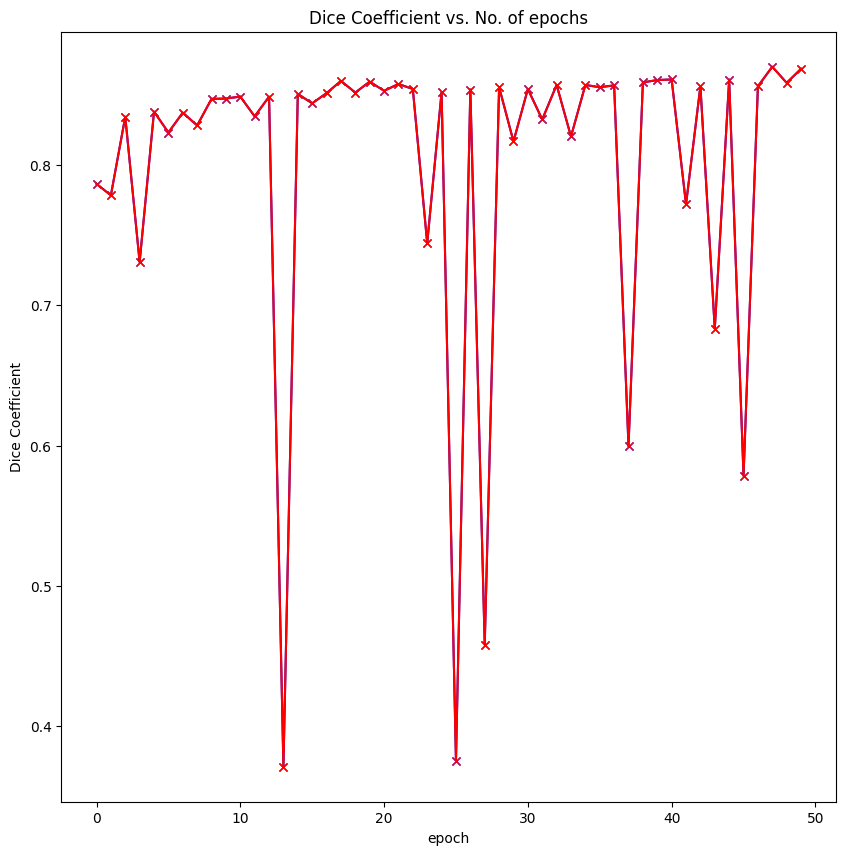

In [17]:
plot_DSC(train_DSC, valid_DSC)


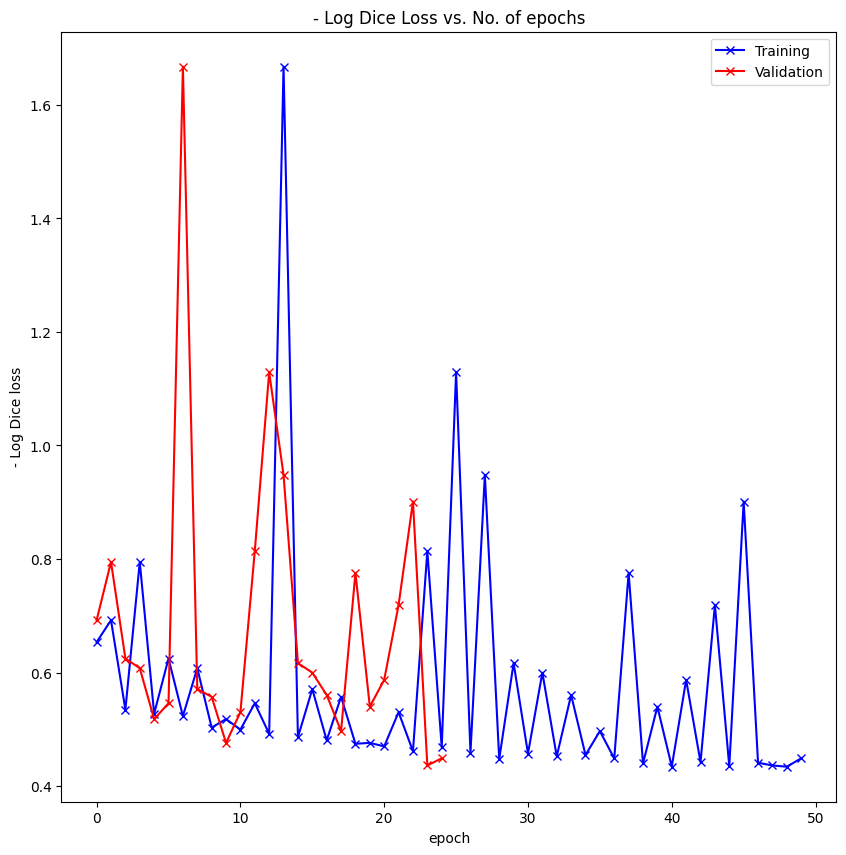

In [18]:
plot_losses(train_losses, valid_losses)

In [157]:
train_transforms=transforms.Compose([Resize(256),
                                     Normalize([0.485, 0.456, 0.406], [0.229, 0.224,0.225])])

In [19]:
base_path2 = Path('./data/prueba_de_fuego_xd/')
red_dir2   = base_path2/'train_red'
blue_dir2  = base_path2/'train_blue'
green_dir2 = base_path2/'train_green'
nir_dir2   = base_path2/'train_nir'
gt_dir2   = base_path2/'train_gt'

RGBdata2 = RGBCloudDataset(red_dir2, blue_dir2, green_dir2, gt_dir2,n_samples=2)  

In [20]:
RGBtest_loader2  = DataLoader(RGBdata2 , batch_size=32, shuffle=False, num_workers=2)


In [22]:
ResNet_model2= ResNet34FCN_384(pretrained=False).to(device)

/home/caloja/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caloja/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
ResNet_model2.load_state_dict(torch.load('./Pretrained_ResNet34_DiceScore_lr4_bs32.pt'))

<All keys matched successfully>

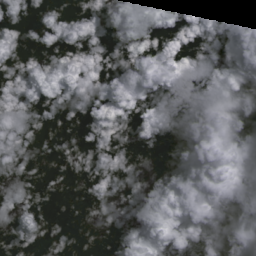

In [24]:
RGBdata2.open_as_pil(0)

In [33]:
ResNet_model2.eval()

ResNet34FCN_384(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [34]:
with torch.no_grad():
    for rgb_img, mask in RGBtest_loader2:
        
        rgb_img, mask = rgb_img.to(device), mask.to(device)
        
        output = ResNet_model2(rgb_img)
        output = torch.round(output.softmax(dim=1))
        output = output.cpu().numpy()
        mask   = mask.cpu().numpy()
        rgb_img= rgb_img.cpu().numpy()
        break

In [35]:
mask[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [36]:
output[0].shape

(2, 256, 256)

In [37]:
# for i, (rgb, gt) in enumerate(RGBtest_loader2):
#     print(f'batch {i+1}:')
#     # some plots
#     for i in range(1):
#         plt.figure(figsize=(10, 5))
#         plt.subplot(221)
#         plt.imshow(rgb[i].squeeze().permute(1, 2, 0))
#         plt.title(f'RGB img{i+1}')
#         plt.subplot(222)
#         plt.imshow(gt[i].squeeze().permute(1, 2, 0))
#         plt.title(f'GT img{i+1}')
#         plt.show()

In [38]:
RGBdata2.OpenAsArray(0, invert=True).shape

(3, 256, 256)

In [39]:
rgb_img[0].transpose(1,2,0).shape

(256, 256, 3)

Text(0.5, 1.0, 'Predicted Cloud Mask')

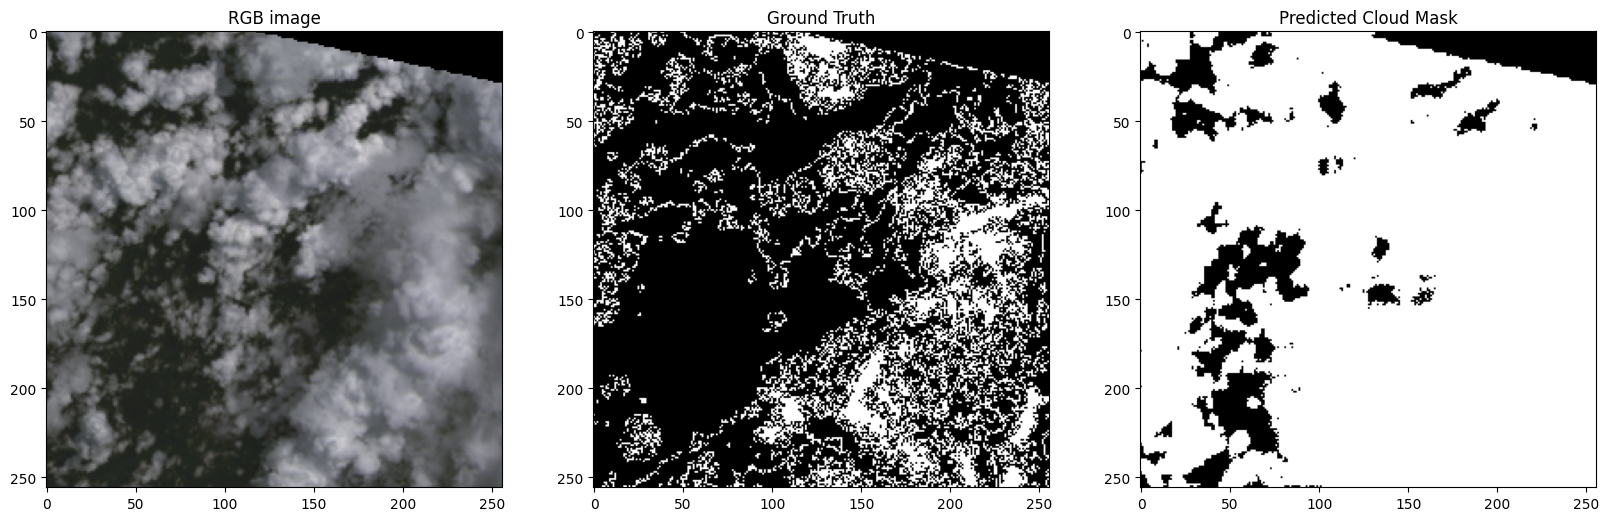

In [41]:
# plot img predicted 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(rgb_img[0].transpose(1,2,0))
ax[0].set_title('RGB image')
ax[1].imshow(mask[0], cmap='gray')
ax[1].set_title('Ground Truth')
ax[2].imshow(output[0][1], cmap='gray')
ax[2].set_title('Predicted Cloud Mask')
